<a href="https://colab.research.google.com/github/NanaKwakuOsei-Opoku/Interpretable-Landslide-Detection-System/blob/main/Landslide4Sense_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation of required libraries and basic setup

In [6]:
from google.colab import drive
drive.mount("/content/gdrive")
import os
import glob
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%cd /content/gdrive/MyDrive/Colab\ Notebooks
!ls
from utils import recall_m, precision_m, f1_m


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks
'Copy of Landslide4Sense solution.ipynb'  'Landslide4Sense solution.ipynb'   __pycache__   utils.py
 data					   model			     Unet.py


# Data Loading & Preprocessing

In [ ]:
import numpy as np
import h5py

def load_dataset(image_paths, mask_paths=None):
    valid_images = []
    valid_masks = [] if mask_paths is not None else None
    corrupted_images_count = 0
    corrupted_masks_count = 0

    for i, img_path in enumerate(image_paths):
        try:
            with h5py.File(img_path, 'r') as hdf:
                data = np.array(hdf.get('img'), dtype=np.float32)
        except Exception as e:
            print(f"Skipping image file {img_path} due to error: {e}")
            corrupted_images_count += 1
            continue  # Skip this file if an error occurs

        # Replace NaNs and compute mid values
        data[np.isnan(data)] = 1e-6
        mid_rgb       = data[:, :, 1:4].max() / 2.0
        mid_slope     = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # NDVI calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        ndvi = np.divide(data_nir - data_red,
                         (data_nir + data_red) + 1e-6)

        # Build the output image array (128 x 128 with 6 channels)
        img_array = np.empty((128, 128, 6), dtype=np.float32)
        img_array[:, :, 0] = 1.0 - (data[:, :, 3] / (mid_rgb + 1e-6))     # R
        img_array[:, :, 1] = 1.0 - (data[:, :, 2] / (mid_rgb + 1e-6))     # G
        img_array[:, :, 2] = 1.0 - (data[:, :, 1] / (mid_rgb + 1e-6))     # B
        img_array[:, :, 3] = ndvi
        img_array[:, :, 4] = 1.0 - (data[:, :, 12] / (mid_slope + 1e-6))  # Slope
        img_array[:, :, 5] = 1.0 - (data[:, :, 13] / (mid_elevation + 1e-6))  # Elevation

        valid_images.append(img_array)

        # Load corresponding mask if provided
        if mask_paths is not None:
            try:
                with h5py.File(mask_paths[i], 'r') as hdf_mask:
                    mask_data = np.array(hdf_mask.get('mask'), dtype=np.float32)
                valid_masks.append(mask_data)
            except Exception as e:
                print(f"Skipping mask file {mask_paths[i]} due to error: {e}")
                corrupted_masks_count += 1
                continue

    X = np.array(valid_images)
    Y = np.array(valid_masks) if mask_paths is not None else None

    # Print summary statistics
    print("Dataset loading completed:")
    print(f"Total image files provided: {len(image_paths)}")
    print(f"Valid images loaded: {X.shape[0]}")
    print(f"Corrupted/failed image files: {corrupted_images_count}")

    if mask_paths is not None:
        print(f"Total mask files provided: {len(mask_paths)}")
        print(f"Valid masks loaded: {Y.shape[0]}")
        print(f"Corrupted/failed mask files: {corrupted_masks_count}")

        # Count landslide positive (mask has any non-zero value) vs. non-landslide images.
        positive_count = 0
        negative_count = 0
        for mask in Y:
            # Adjust the threshold if needed; here, any pixel > 0 counts as positive.
            if np.sum(mask) > 0:
                positive_count += 1
            else:
                negative_count += 1

        print(f"Landslide positive images (mask > 0): {positive_count}")
        print(f"Non-landslide images (mask sum == 0): {negative_count}")

    return X, Y


# Preparing Training and Validation

Dataset loading completed:
Total image files provided: 100
Valid images loaded: 100
Corrupted/failed image files: 0
Total mask files provided: 100
Valid masks loaded: 100
Corrupted/failed mask files: 0
Landslide positive images (mask > 0): 84
Non-landslide images (mask sum == 0): 16
Train data shape: (100, 128, 128, 6) (100, 128, 128)
Train stats: -0.9999995 1.0 0.0 1.0


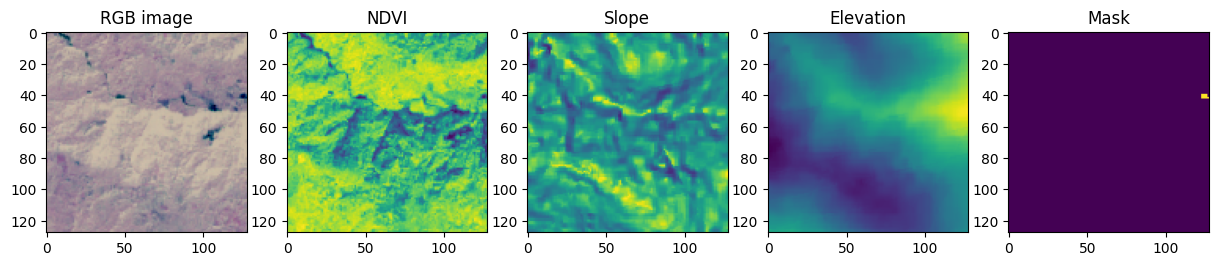

In [5]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/data')

TRAIN_PATH = sorted(glob.glob("/content/gdrive/MyDrive/Colab Notebooks/data/TrainData/img/*.h5"))[:100]
TRAIN_MASK = sorted(glob.glob("/content/gdrive/MyDrive/Colab Notebooks/data/TrainData/mask/*.h5"))[:100]


#Load entire training set
TRAIN_XX, TRAIN_YY = load_dataset(TRAIN_PATH, TRAIN_MASK)

print("Train data shape:", TRAIN_XX.shape, TRAIN_YY.shape)
if TRAIN_XX.size > 0 and TRAIN_YY.size > 0:
    print("Train stats:", TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())
else:
    print("No data loaded. Check file paths and dataset.")


#Train/validation split
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(
    TRAIN_XX, TRAIN_YY, test_size=0.2, shuffle=True
)

del TRAIN_XX, TRAIN_YY  # free memory if desired

# After train_test_split:
y_train = np.expand_dims(y_train, axis=-1)  # Shape (80, 128, 128, 1)
y_valid = np.expand_dims(y_valid, axis=-1)  # Shape (20, 128, 128, 1)



# Quick visualization
sample_idx = 5
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 10))
ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")

ax1.imshow(x_train[sample_idx, :, :, 0:3])
ax2.imshow(x_train[sample_idx, :, :, 3])
ax3.imshow(x_train[sample_idx, :, :, 4])
ax4.imshow(x_train[sample_idx, :, :, 5])
ax5.imshow(y_train[sample_idx, :, :])
plt.show()

## Building and Compiling the UNET


In [7]:
import tensorflow as tf

def unet_model(img_height, img_width, img_channels):
    inputs = tf.keras.layers.Input((img_height, img_width, img_channels))

    # Contracting path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                                kernel_initializer='he_normal',
                                padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                                kernel_initializer='he_normal',
                                padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal',
                                padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal',
                                padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal',
                                padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal',
                                padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal',
                                padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal',
                                padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu',
                                kernel_initializer='he_normal',
                                padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu',
                                kernel_initializer='he_normal',
                                padding='same')(c5)

    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2),
                                         padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal',
                                padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal',
                                padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2),
                                         padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal',
                                padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal',
                                padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2),
                                         padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal',
                                padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal',
                                padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2),
                                         padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                                kernel_initializer='he_normal',
                                padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                                kernel_initializer='he_normal',
                                padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)  # Shape: (None, 128, 128, 1)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model




## Training with Callbacks


In [8]:
model = unet_model(128, 128, 6)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[f1_m, precision_m, recall_m]  # Use updated metrics
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "/content/gdrive/MyDrive/Colab Notebooks/model/best_model.keras",
        monitor="val_f1_m",
        verbose=1,
        save_best_only=True,
        mode="max"
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_f1_m',
        patience=10,
        verbose=1,
        mode='max',
        restore_best_weights=True
    )
]

history = model.fit(
    x_train, y_train,
    batch_size=16,
    epochs=10,
    verbose=2,
    validation_data=(x_valid, y_valid),
    callbacks=callbacks
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(16, 128, 128, 6))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 6))
  warnings.warn(msg)



Epoch 1: val_f1_m improved from -inf to 0.02433, saving model to /content/gdrive/MyDrive/Colab Notebooks/model/best_model.keras
5/5 - 49s - 10s/step - f1_m: 0.0440 - loss: 0.7843 - precision_m: 0.0239 - recall_m: 0.4774 - val_f1_m: 0.0243 - val_loss: 0.4813 - val_precision_m: 0.0397 - val_recall_m: 0.0176
Epoch 2/10

Epoch 2: val_f1_m did not improve from 0.02433
5/5 - 27s - 5s/step - f1_m: 0.0336 - loss: 0.2930 - precision_m: 0.0313 - recall_m: 0.0479 - val_f1_m: 0.0196 - val_loss: 0.1515 - val_precision_m: 0.0729 - val_recall_m: 0.0113
Epoch 3/10

Epoch 3: val_f1_m did not improve from 0.02433
5/5 - 39s - 8s/step - f1_m: 0.0111 - loss: 0.1429 - precision_m: 0.0269 - recall_m: 0.0072 - val_f1_m: 5.3792e-04 - val_loss: 0.1228 - val_precision_m: 0.0250 - val_recall_m: 2.7189e-04
Epoch 4/10

Epoch 4: val_f1_m did not improve from 0.02433
5/5 - 40s - 8s/step - f1_m: 0.0050 - loss: 0.1283 - precision_m: 0.0289 - recall_m: 0.0027 - val_f1_m: 0.0000e+00 - val_loss: 0.1158 - val_precision_m:

## Evaluate

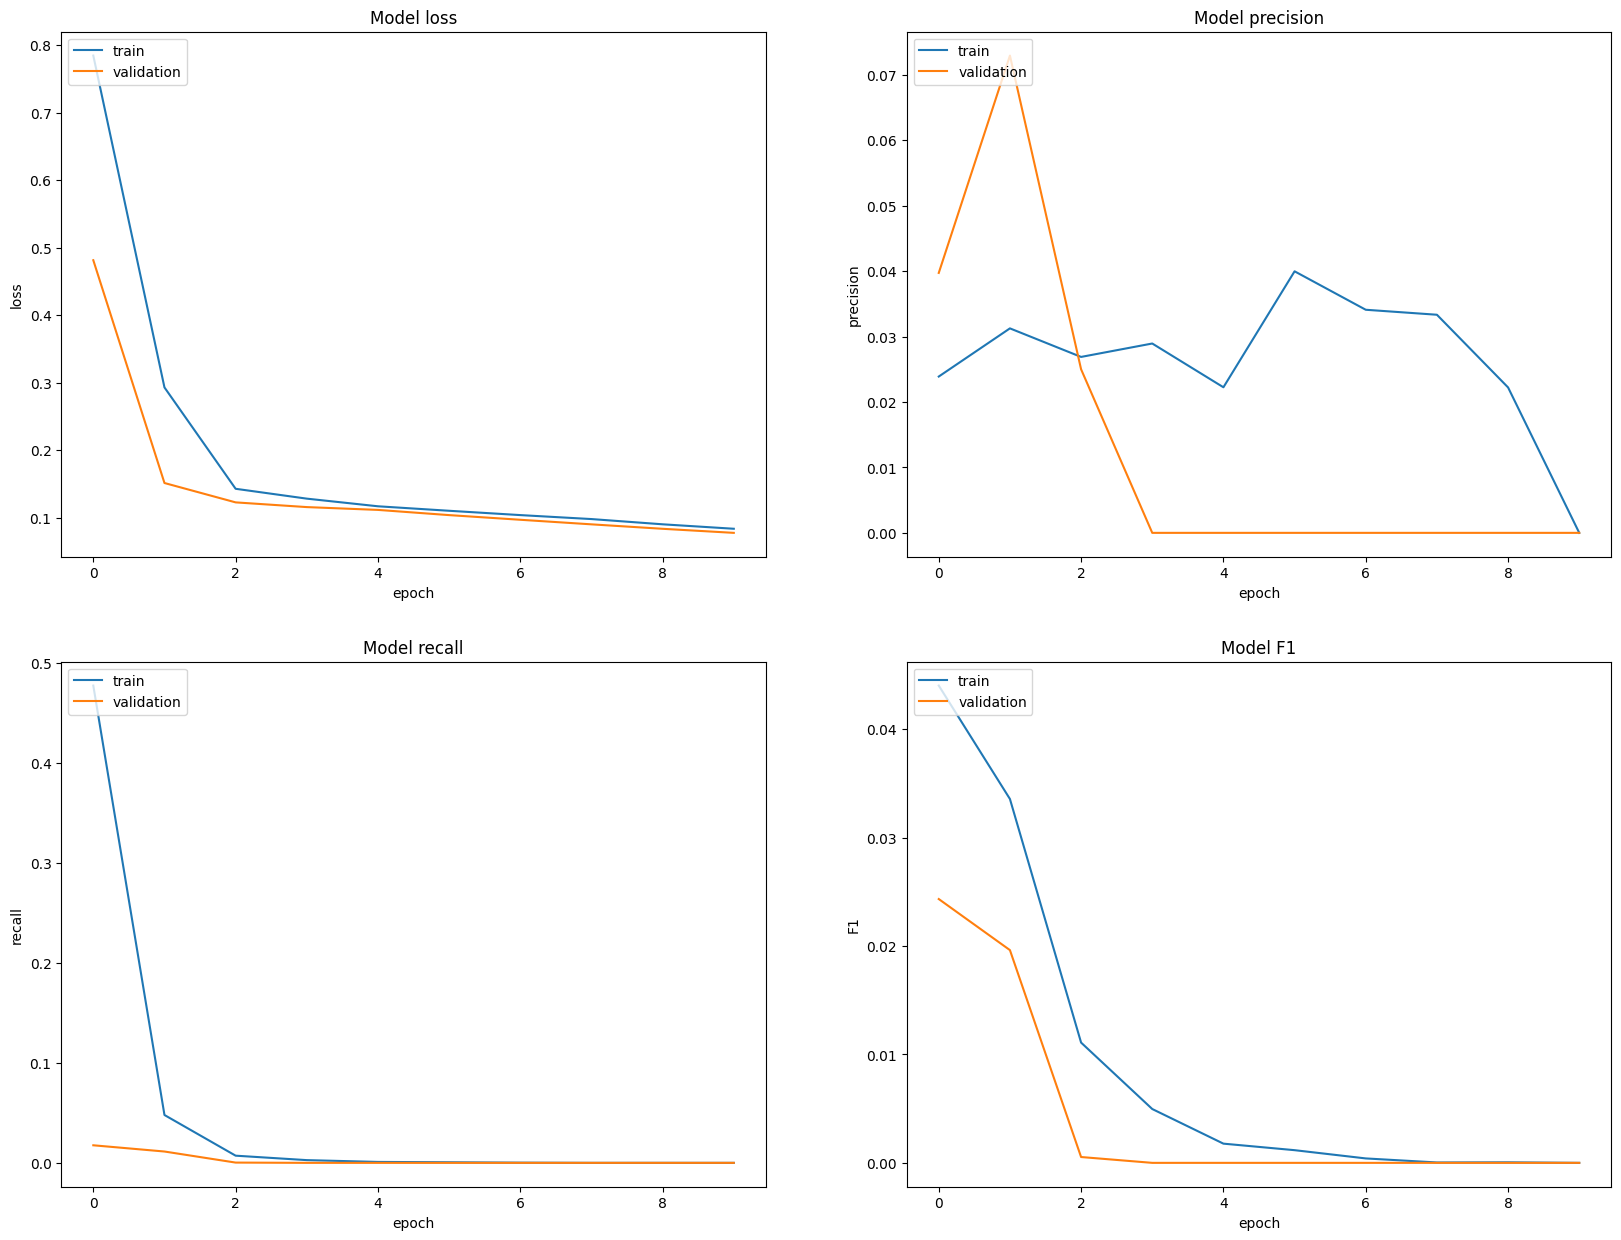

In [9]:
# # Evaluate
# loss, accuracy, f1_score, precision, recall = model.evaluate(x_valid, y_valid, verbose=0)
# print("Final validation metrics:")
# print("Loss:", loss, "Accuracy:", accuracy,
#       "F1:", f1_score, "Precision:", precision, "Recall:", recall)

# Plot training history
fig, ((ax11, ax12), (ax13, ax14)) = plt.subplots(2, 2, figsize=(20, 15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.set_title('Model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Model F1')
ax14.set_ylabel('F1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')
plt.show()


## Prediction Example

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(20, 128, 128, 6))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


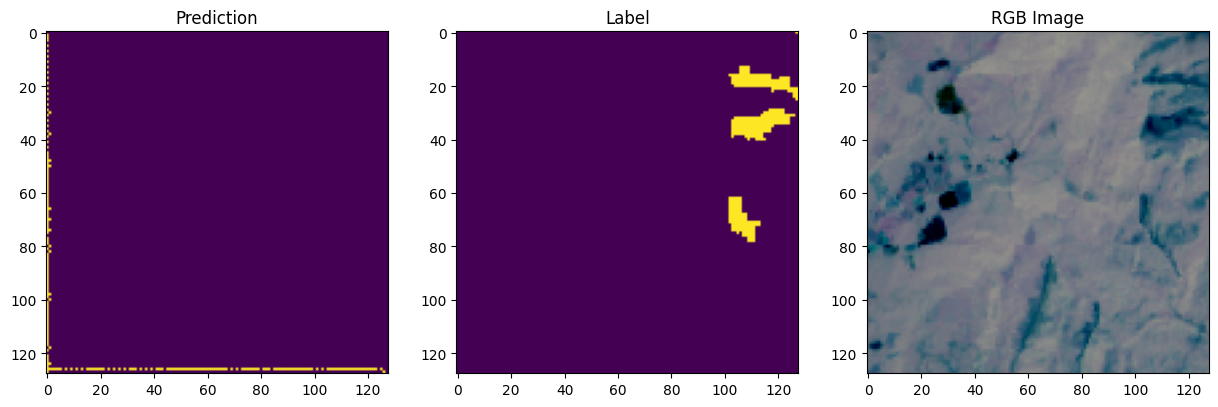

In [10]:
threshold = 0.5
pred_img = model.predict(x_valid)
pred_img = (pred_img > threshold).astype(np.uint8)

img_idx = 7
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
ax1.imshow(pred_img[img_idx, :, :, 0])
ax1.set_title("Prediction")
ax2.imshow(y_valid[img_idx, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img_idx, :, :, 0:3])
ax3.set_title("RGB Image")
plt.show()


## Validating on New Data

Dataset loading completed:
Total image files provided: 245
Valid images loaded: 245
Corrupted/failed image files: 0
Validation images shape: (245, 128, 128, 6)
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


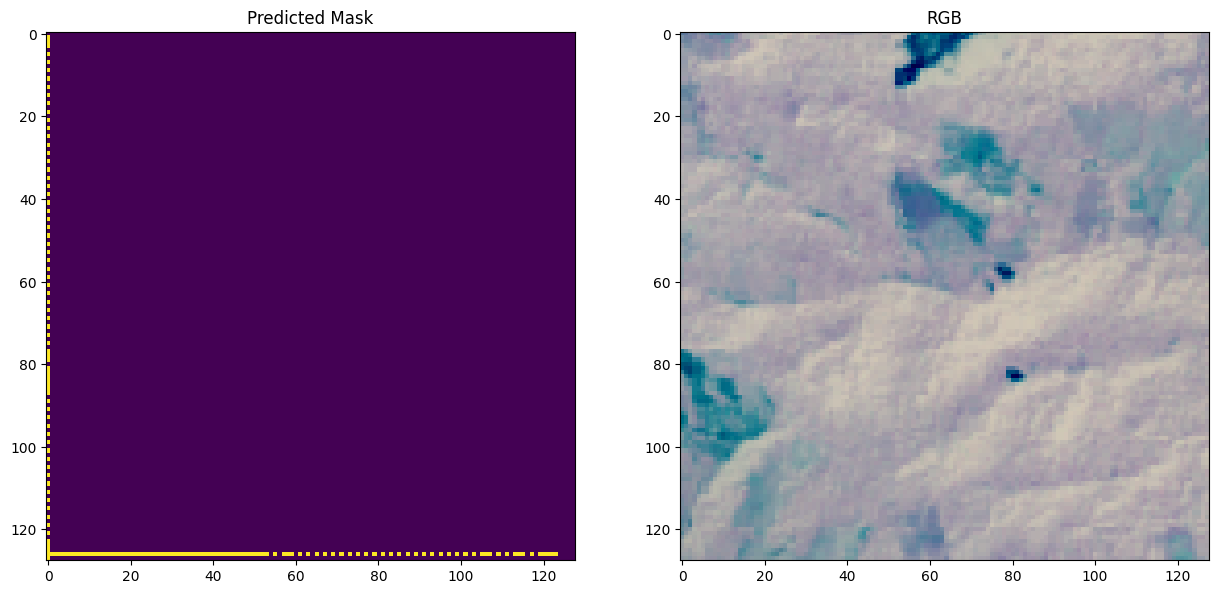

In [12]:
validation_url = ("/content/gdrive/MyDrive/Colab Notebooks/data/ValidateData/*.h5")
img_val_paths = sorted(glob.glob(validation_url))

VAL_XX, _ = load_dataset(img_val_paths, mask_paths=None)  # no masks here
print("Validation images shape:", VAL_XX.shape)

# Predict
val_preds = model.predict(VAL_XX)
val_preds = (val_preds > threshold).astype(np.uint8)

# Quick look
img_val_idx = 10
fig, (axv1, axv2) = plt.subplots(1, 2, figsize=(15, 10))
axv1.imshow(val_preds[img_val_idx, :, :, 0])
axv1.set_title("Predicted Mask")
axv2.imshow(VAL_XX[img_val_idx, :, :, 0:3])
axv2.set_title("RGB")
plt.show()

# OPTIONAL: Save out predicted masks
write_directory = "data/validation/mask"
os.makedirs(write_directory, exist_ok=True)
for i, img_path in enumerate(img_val_paths):
    # Build output mask name from input name
    name = os.path.basename(img_path).replace("image", "mask")
    with h5py.File(os.path.join(write_directory, name), 'w') as h5f:
        pred_mask = val_preds[i, :, :, 0]
        h5f.create_dataset('mask', data=pred_mask)


## Interpretability: Saliency Map & Grad-CAM

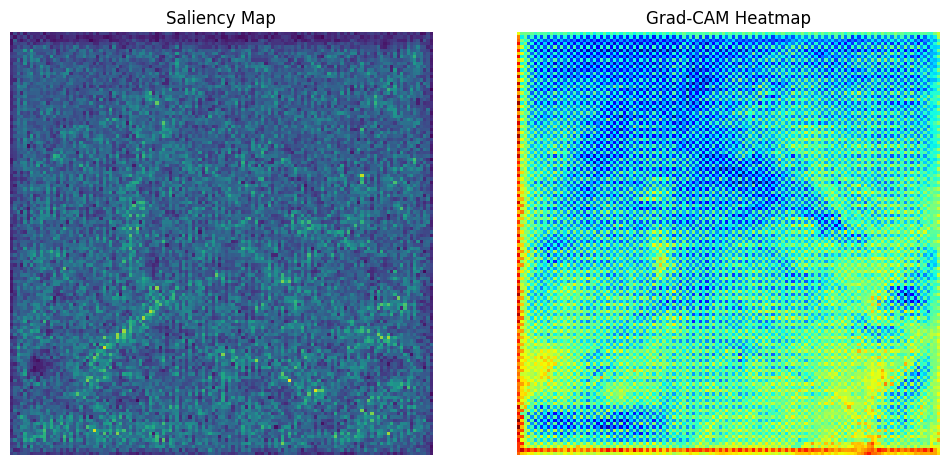

In [14]:
import cv2
import tensorflow.keras.backend as K

def compute_saliency(model, x, class_idx=None):
    x_var = tf.Variable(x, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x_var)
        prediction = model(x_var, training=False)  # shape: (1, H, W, 1)
        if class_idx is not None:
            # If we wanted a specific pixel or region, we'd index into prediction
            # e.g. prediction[0, row, col, 0]
            loss = prediction[0, :, :, 0][class_idx]
        else:
            # Sum over entire predicted mask
            loss = tf.reduce_sum(prediction)
    # Compute gradient of the loss w.r.t. the input
    grads = tape.gradient(loss, x_var)
    # Take absolute value across channels, then max
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]
    return saliency.numpy()

def grad_cam_segmentation(model, x, layer_name=None):
    if layer_name is None:
        layer_name = [l.name for l in model.layers if 'conv2d' in l.name][-1]  # Pick the last conv layer

    # Build a sub-model that returns (feature_maps, predictions)
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[
            model.get_layer(layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        feature_maps, predictions = grad_model(x, training=False)
        loss = tf.reduce_sum(predictions)

    grads = tape.gradient(loss, feature_maps)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    feature_maps = feature_maps[0]  # Remove batch dimension
    heatmap = tf.reduce_sum(tf.multiply(feature_maps, pooled_grads), axis=-1)

    # Apply ReLU using TensorFlow
    heatmap = tf.maximum(heatmap, 0)
    # Normalize the heatmap
    max_val = tf.reduce_max(heatmap)
    heatmap = heatmap / (max_val + 1e-6)
    # Convert to NumPy array once, after all TensorFlow operations
    heatmap = heatmap.numpy()

    # Resize to match original input size
    h, w = x.shape[1], x.shape[2]
    heatmap = cv2.resize(heatmap, (w, h))
    return heatmap


# Example usage on one validation image
test_img = x_valid[None, 0, ...]  # shape (1, 128, 128, 6)
saliency_map = compute_saliency(model, test_img)
gradcam_map = grad_cam_segmentation(model, test_img, layer_name=None)

fig, (ax_s, ax_g) = plt.subplots(1, 2, figsize=(12, 6))
ax_s.imshow(saliency_map, cmap='viridis')
ax_s.set_title("Saliency Map")
ax_s.axis('off')

ax_g.imshow(gradcam_map, cmap='jet')
ax_g.set_title("Grad-CAM Heatmap")
ax_g.axis('off')
plt.show()

# Sensitivity Analysis


In [ ]:
def channel_sensitivity(model, x, channel_idx, baseline='zero'):
    original_pred = model.predict(x)[0, :, :, 0]

    x_mod = x.copy()
    if baseline == 'zero':
        x_mod[0, :, :, channel_idx] = 0.0
    else:
        # set channel to mean value
        mean_val = np.mean(x_mod[0, :, :, channel_idx])
        x_mod[0, :, :, channel_idx] = mean_val

    new_pred = model.predict(x_mod)[0, :, :, 0]
    diff = np.abs(original_pred - new_pred)
    mean_diff = diff.mean()
    return mean_diff

# Example usage: measure each channel’s importance
test_img = x_valid[None, 0, ...]  # pick one image
num_channels = test_img.shape[-1]
for c in range(num_channels):
    sensitivity = channel_sensitivity(model, test_img, c, baseline='zero')
    print(f"Channel {c} sensitivity (zero baseline):", sensitivity)

## Implementing LIME

In [ ]:

from lime import lime_image
from skimage.segmentation import slic


def explain_with_lime(model, image, num_samples=1000):
    explainer = lime_image.LimeImageExplainer()

    # Function to predict using the U-Net model; note that LIME expects a 3D image input
    def model_predict(images):
        images = np.array(images)
        # Assuming images are 128x128 with 6 channels
        preds = model.predict(images)
        # Return predictions in a suitable format; for segmentation, you might flatten the output or summarize per region.
        return preds.reshape((images.shape[0], -1))

    explanation = explainer.explain_instance(
        image.astype('double'),
        model_predict,
        top_labels=1,
        hide_color=0,
        num_samples=num_samples,
        segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10)
    )
    return explanation

# Select a representative validation image (e.g., the same test_img used for saliency/Grad-CAM)
lime_explanation = explain_with_lime(model, x_valid[0])

# Visualize the explanation (this depends on how you want to overlay the superpixel weights)
temp, mask = lime_explanation.get_image_and_mask(
    label=lime_explanation.top_labels[0],
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

plt.imshow(temp)
plt.title("LIME Explanation")
plt.axis('off')
plt.show()
